<a href="https://colab.research.google.com/github/LuckieMusngi/TicTacToe/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

380 Project


---


Group: Luckie Musungi, Tristan J Emma, Yashi Gupta

# Imports and mounting to drive

In [ ]:
#All finalised needed imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn import linear_model

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import warnings


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data from CSVs

*   Tucson Police Arrests 2021
*   Tucson NeighborHood Income
*   Tucson Neighborhood Race and Demographics
*   Tucson Neighborhood Population Statistics






In [ ]:
#* Load the data
# https://gisdata.tucsonaz.gov/datasets/cotgis::tucson-police-arrests-2021-open-data/explore?location=32.461749%2C-111.225550%2C8.80
arrests = pd.read_csv('/content/drive/My Drive/datasets/Tucson_Police_Arrests_-_2021_-_Open_Data.csv')
# https://gisdata.tucsonaz.gov/datasets/59f033d07eae41b0bdc21db87375d721_0/explore?location=32.217806%2C-110.903274%2C11.18
income = pd.read_csv('/content/drive/My Drive/datasets/Neighborhood_Income.csv')
# https://gisdata.tucsonaz.gov/datasets/35fda63efad14a7b8c2a0a68d77020b7_0/explore?location=25.505965%2C-115.013518%2C17.36
races = pd.read_csv('/content/drive/My Drive/datasets/Neighborhood_Race_Demographics.csv')
# https://gisdata.tucsonaz.gov/datasets/cotgis::neighborhood-population-statistics/explore
population = pd.read_csv('/content/drive/My Drive/datasets/Neighborhood_Population_Statistics.csv')

# Aggregate data into dataframes

Get data from Arrests CSV

In [ ]:
#* Counts arrests per neighberhood to start (NAME, arrest count)
arrest_stats_raw = arrests.groupby('NHA_NAME').size().reset_index(name='Arrest Count')


#* Counts the average age for each arrest per neighborhood (average age)
df_ages = arrests[['NHA_NAME', 'age']].groupby('NHA_NAME').agg(list).reset_index()
# ignore ages that don't exist
df_ages['age'] = df_ages['age'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# take average
df_ages['Average Arrest Age'] = df_ages['age'].apply(lambda x: np.nanmean(x))
# age is no longer necessary
df_ages.drop(columns=['age'], inplace=True)

Get data from Income CSV

In [ ]:
#* Counts the average income for each neighborhood (average income, total households)
df_income = income[['NAME', 'AVGHINC_CY', 'TOTHH_CY']]
df_income = df_income.rename(columns={'AVGHINC_CY': 'Average Income', 'TOTHH_CY': 'Total Households'})

Get data from Demographics CSV

In [ ]:
#* Counts the # of each race per neighberhood (white, black, american indian, asian, pacific islander, other, multiple)
df_races = races[['NAME', 'WHITE_CY', 'BLACK_CY', 'AMERIND_CY', 'ASIAN_CY', 'PACIFIC_CY', 'OTHRACE_CY', 'RACE2UP_CY', 'HISPPOP_CY']]
df_races = df_races.rename(columns={'WHITE_CY': 'White', 'BLACK_CY': 'Black', 'AMERIND_CY': 'American Indian', 'ASIAN_CY': 'Asian',
                                    'PACIFIC_CY': 'Pacific Islander', 'OTHRACE_CY': 'Other (race)', 'RACE2UP_CY': 'Multiple Races', 'HISPPOP_CY': 'Hispanic'})

Get data from Population CSV

In [ ]:
#* Counts the population per neighborhood (population)
df_population = population[['NAME', 'TOTPOP_CY']]
df_population = df_population.rename(columns={'TOTPOP_CY': 'Population'})

# Merge into 1 dataframe

In [ ]:
#* Merges them all into one
# arrest_stats_raw = Name, Arrest Count, Average Arrest Age, Average Income, Total Households, [Races], Population
arrest_stats_raw = arrest_stats_raw.merge(df_ages, on='NHA_NAME')
# the rest of the stats use NAME instead of NHA_NAME
arrest_stats_raw = arrest_stats_raw.rename(columns={'NHA_NAME': 'NAME'})
arrest_stats_raw = arrest_stats_raw.merge(df_income, on='NAME')
arrest_stats_raw = arrest_stats_raw.merge(df_races, on='NAME')
arrest_stats_raw = arrest_stats_raw.merge(df_population, on='NAME')

# for consistency
arrest_stats_raw = arrest_stats_raw.rename(columns={'NAME': 'Name'})

# Create final dataframe for analysis

Turn statistics into percentages and ratios that are usable and account for population

In [ ]:
#* Cleans up the data
# arrest_stats = Name, Arrest Count, Average Arrest Age, Average Income, [% Races], Population/Household, Arrests/Capita
arrest_stats = arrest_stats_raw.copy()
arrest_stats['% White'] = arrest_stats['White'] / arrest_stats['Population']
arrest_stats['% Black'] = arrest_stats['Black'] / arrest_stats['Population']
arrest_stats['% Hispanic'] = arrest_stats['Hispanic'] / arrest_stats['Population']
arrest_stats['% Asian'] = arrest_stats['Asian'] / arrest_stats['Population']
arrest_stats['% Pacific Islander'] = arrest_stats['Pacific Islander'] / arrest_stats['Population']
arrest_stats['% American Indian'] = arrest_stats['American Indian'] / arrest_stats['Population']
arrest_stats['% Multiple Races'] = arrest_stats['Multiple Races'] / arrest_stats['Population']
arrest_stats['% Other (race)'] = arrest_stats['Other (race)'] / arrest_stats['Population']
arrest_stats['Population/Household'] = arrest_stats['Population'] / arrest_stats['Total Households']
arrest_stats['Arrests/Capita'] = arrest_stats['Arrest Count'] / arrest_stats['Population']

Drop unneeded statistics

In [ ]:
# these were all used to get percentages
arrest_stats.drop(columns=['White', 'Black', 'Hispanic', 'Asian',\
                           'Pacific Islander', 'American Indian',\
                           'Multiple Races', 'Other (race)', 'Population',\
                           'Total Households'], inplace=True)

Create our 'y' column, categorize data by arrests/capita and assign a value accordingly

In [ ]:
#* Gets crime level (-1 = low, 0 = medium, 1 = high)
# arrest_stats = Name, Arrest Count, Average Arrest Age, Average Income, [% Races], Population/Household, Arrests/Capita
def determine_crime_level(row):
    if row['Arrests/Capita'] > arrest_stats['Arrests/Capita'].quantile(0.67):
        return 1  # High
    elif row['Arrests/Capita'] > arrest_stats['Arrests/Capita'].quantile(0.33):
        return 0  # Medium
    else:
        return -1  # Low
arrest_stats['Crime Category'] = arrest_stats.apply(determine_crime_level, axis=1)
print("Quantile 0.33 cutoff:", arrest_stats['Arrests/Capita'].quantile(0.33))
print("Quantile 0.67 cutoff:", arrest_stats['Arrests/Capita'].quantile(0.67))

Quantile 0.33 cutoff: 0.04202975964703472
Quantile 0.67 cutoff: 0.08680943352954669


# Print Final Dataframe

In [ ]:
#* Prints the data
print(arrest_stats_raw)
print(arrest_stats)

                     Name  Arrest Count  Average Arrest Age  Average Income  \
0              A Mountain            99           31.968750           47471   
1                Adelanto             8           29.625000           41101   
2             Aldea Linda             1           24.000000           67102   
3        Alvernon Heights            23           40.909091           38963   
4                   Amphi          1844           33.067366           31338   
..                    ...           ...                 ...             ...   
152       West University           595           33.327022           45235   
153      Western Hills II            29           35.461538           50347   
154  Westside Development            79           33.746835           74133   
155      Wilshire Heights             4           33.000000           79559   
156           Winterhaven            20           29.100000           70418   

     Total Households  White  Black  American India

# Split data into Train and Test sections

In [ ]:
X = arrest_stats.drop(columns=['Name', 'Arrest Count', 'Crime Category', 'Arrests/Capita'])
y = arrest_stats['Crime Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

display(X_train)

,Average Arrest Age,Average Income,% White,% Black,% Hispanic,% Asian,% Pacific Islander,% American Indian,% Multiple Races,% Other (race),Population/Household
27,35.088889,78153,0.810694,0.037572,0.239884,0.023121,0.001445,0.013006,0.053468,0.059249,2.507246
110,36.486486,69426,0.692042,0.074394,0.268166,0.058824,0.000000,0.029412,0.058824,0.088235,2.156716
80,32.514739,45920,0.637536,0.049223,0.436694,0.054751,0.003159,0.039484,0.052382,0.163464,1.967374
89,31.806818,60066,0.765306,0.051020,0.271586,0.035322,0.001570,0.018053,0.043171,0.086342,2.028662
18,30.608696,48871,0.428201,0.136678,0.636678,0.009516,0.000000,0.061419,0.054498,0.308824,3.042105
...,...,...,...,...,...,...,...,...,...,...,...
9,36.141791,25781,0.509056,0.056921,0.562096,0.054334,0.001294,0.059508,0.064036,0.254851,2.123626
103,23.846154,54317,0.545872,0.059633,0.697248,0.013761,0.013761,0.036697,0.068807,0.261468,2.534884
67,28.473684,74491,0.847804,0.039837,0.233912,0.011236,0.002043,0.013279,0.024515,0.061287,2.026915
117,32.416318,39634,0.619134,0.011845,0.936674,0.002733,0.000000,0.049203,0.023690,0.293850,2.962213


# Graph Correlations of Pairs of Features

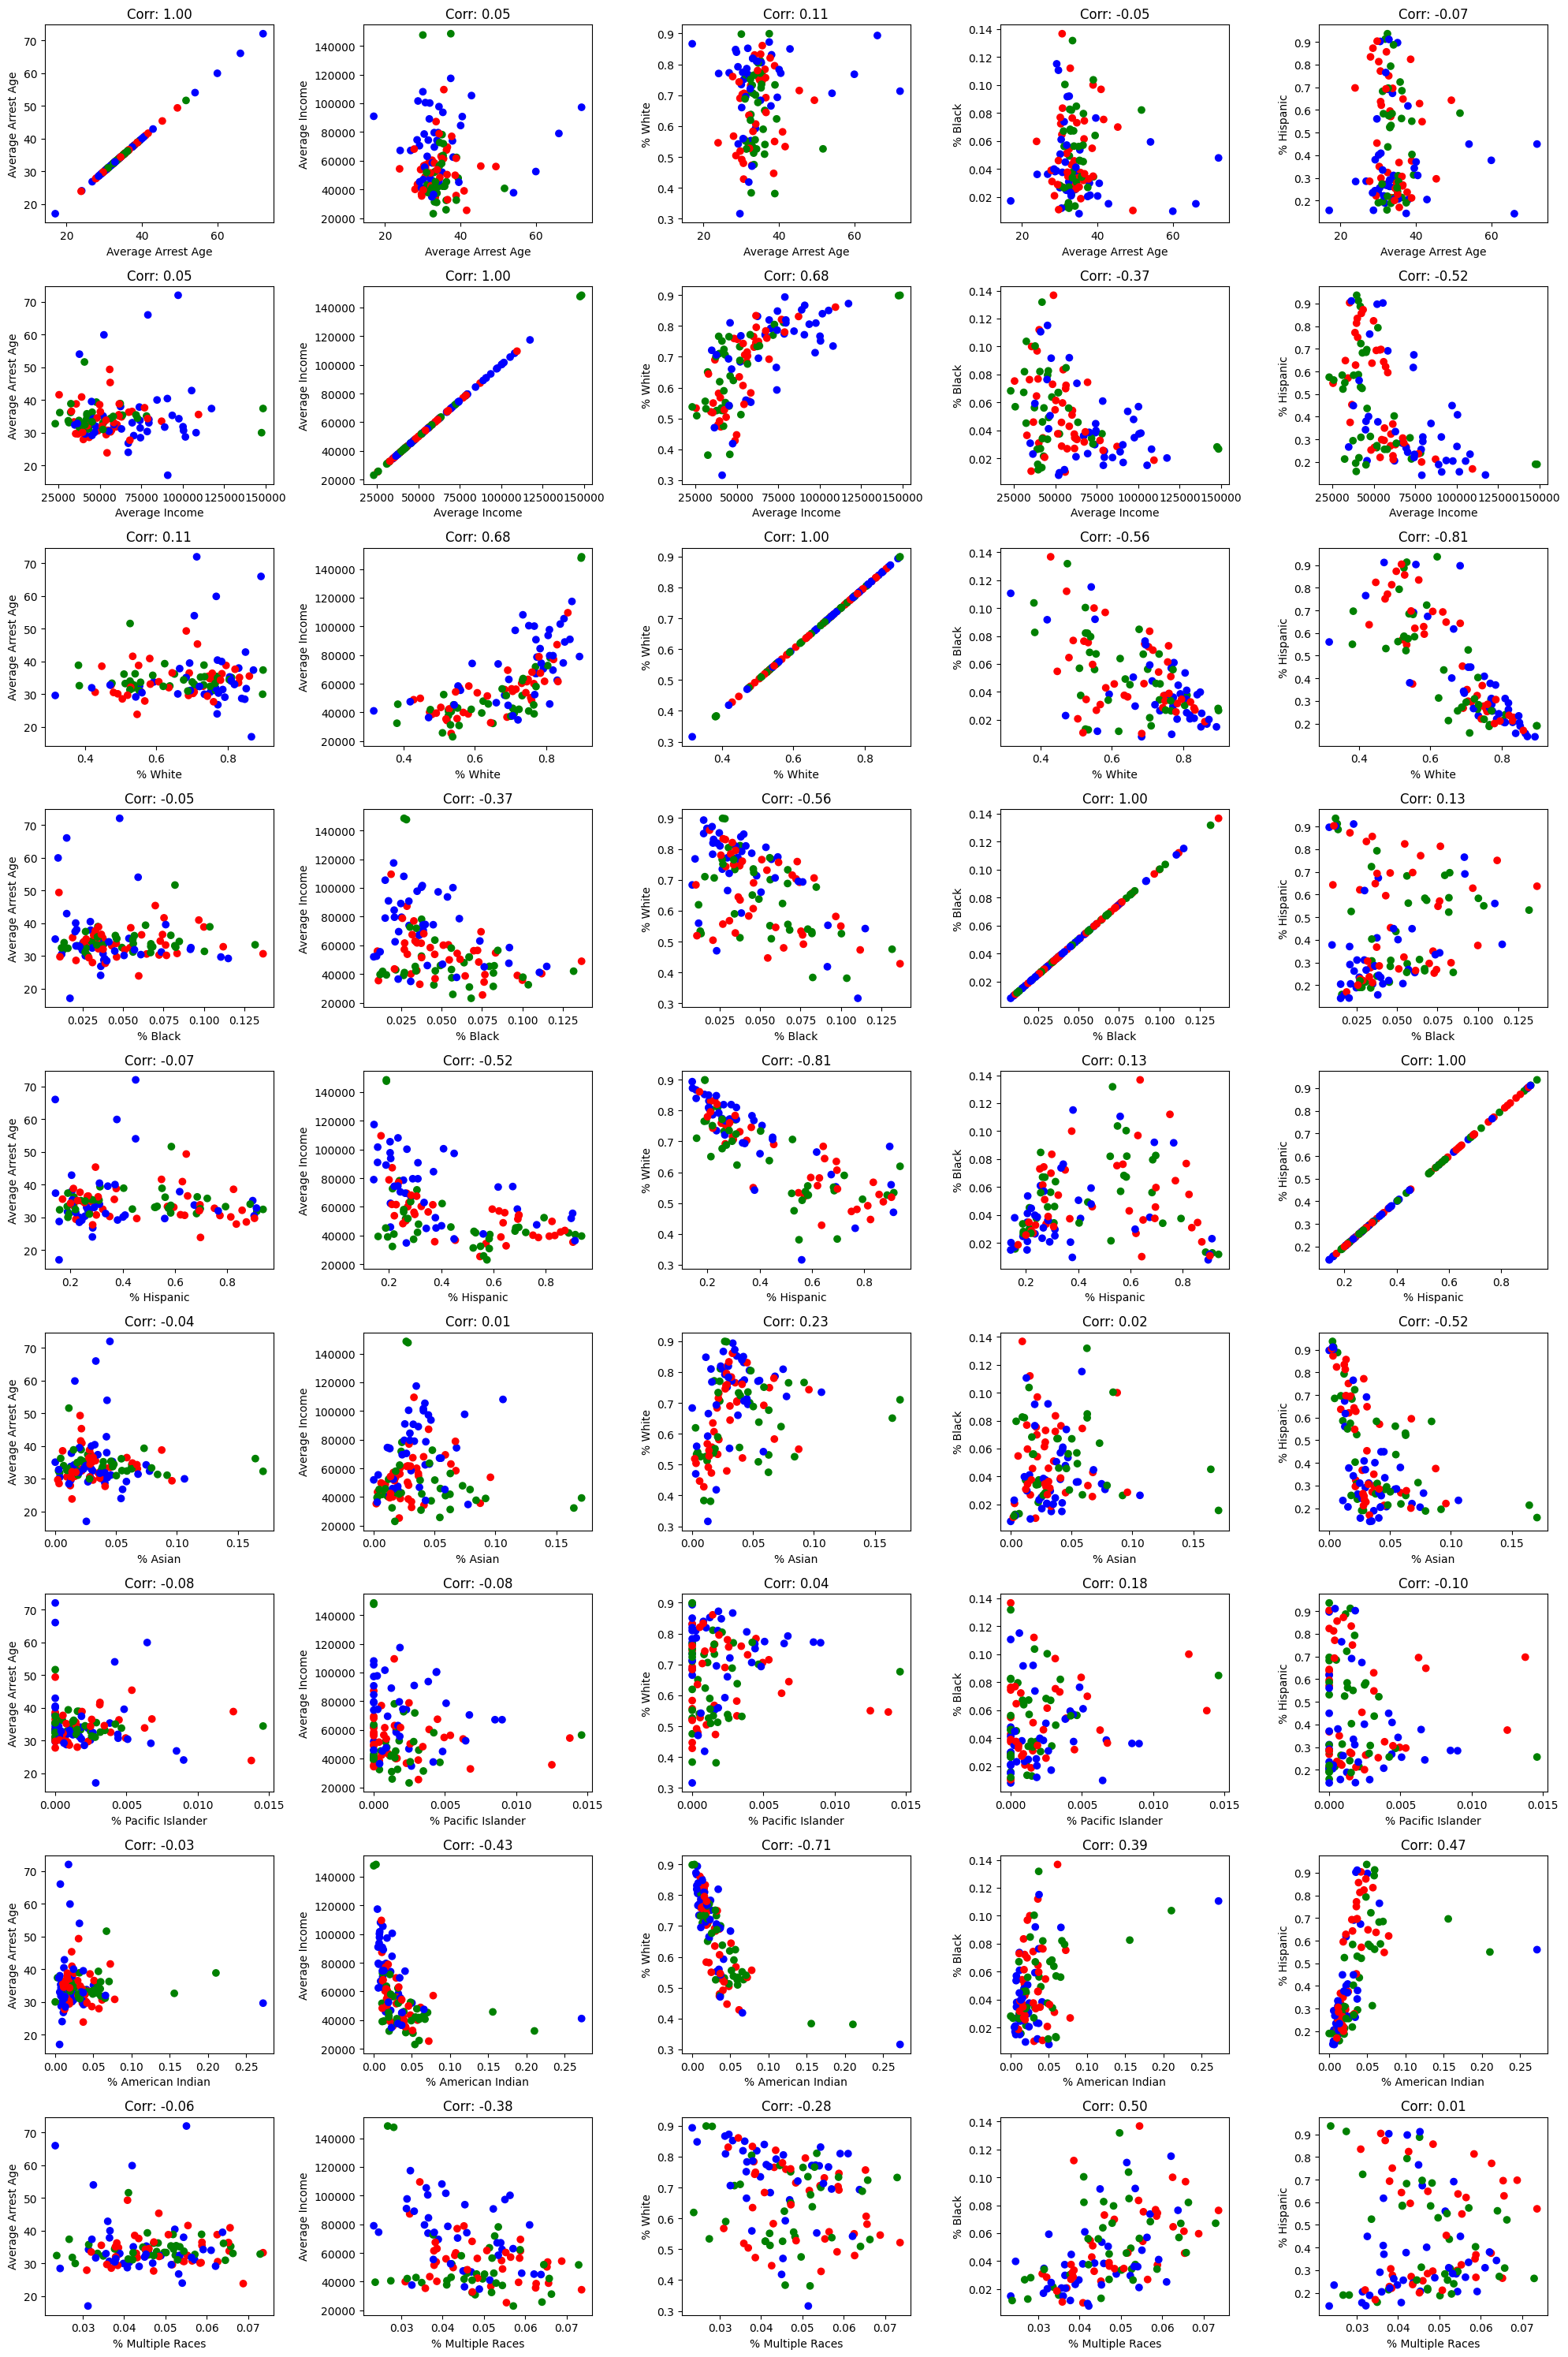

In [ ]:
# initialize true class colors
colors = ['r', 'g', 'b']  # red, green, or blue for the true class label

# Create a 9x5 grid of scatterplots
fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(20, 30))

# List of feature names
features = X_train.columns

# Loop through each pair of features to create scatterplots
for i in range(9):
    for j in range(5):
        if i < len(features) and j < len(features):
            ax = axes[i, j]
            feature_x = features[i]
            feature_y = features[j]

            # Scatter plot with colors based on the true class label
            scatter = ax.scatter(X_train[feature_x], X_train[feature_y], c=[colors[label] for label in y_train])

            # Compute the correlation coefficient
            corr = np.corrcoef(X_train[feature_x], X_train[feature_y])[0, 1]

            # Set plot title with the correlation coefficient
            ax.set_title(f'Corr: {corr:.2f}')

            # Set axis labels
            ax.set_xlabel(feature_x)
            ax.set_ylabel(feature_y)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Explorative Modeling with Logistic Regression

Train various models based on different test inputs and measure accuracies

Testing with race and ethnicity on LogisticRegression. These are the bests stats I saw from some simple playing around.

In [ ]:
lrCV = linear_model.LogisticRegressionCV(cv=5, max_iter=int(1e4), random_state=0, Cs=10)

cvs = cross_val_score(lrCV, X_train.drop(columns=['Average Income', 'Population/Household']), y_train, cv=5, scoring='accuracy')
print(cvs)

cvs = cross_val_score(lrCV, X_train[['% Hispanic']], y_train, cv=5, scoring='accuracy')
print(cvs)

[0.33333333 0.54166667 0.73913043 0.43478261 0.47826087]
[0.33333333 0.5        0.52173913 0.39130435 0.39130435]


Find best performing single feature

In [ ]:
# Initialize LogisticRegressionCV
lrCV = linear_model.LogisticRegressionCV(cv=5, max_iter=int(1e4), random_state=0, Cs=10)

# initialize best accuracy and best feature
best_accuracy = 0
best_feature = None

# iterate over each feature
for i, feature in enumerate(X_train.columns):
    # get current feature as a 2D array (single feature)
    X_feature = X_train[[feature]]

    # fit the LogisticRegressionCV model for the current feature
    lrCV.fit(X_feature, y_train)

    # perform cross fold validation
    cvs = cross_val_score(lrCV, X_feature, y_train, cv=5, scoring='accuracy')

    # get accuracies for each value of C tested during cross-validation
    mean_accuracy = cvs.mean()


    # update the best accuracy and best feature
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_feature = feature

# print best performing feature
print(f"Best Performing Feature: {best_feature}")
print(f"Accuracy:                {best_accuracy:.4f}")

Best Performing Feature: Average Income
Accuracy:                0.5388


Find best performing pair of features

In [ ]:
# Initialize LogisticRegressionCV
lrCV = linear_model.LogisticRegressionCV(cv=5, max_iter=int(1e4), random_state=0, Cs=10)

# Initialize best accuracy and best feature pair
best_accuracy = 0
best_accuarcy_list = []
best_feature_pair = None

# Generate all pairs of features
feature_combinations = itertools.combinations(X_train.columns, 2)

# Iterate over each feature pair
for pair in feature_combinations:
    # Get current pair of features as a 2D array
    X_pair = X_train[list(pair)]

    # Fit the LogisticRegressionCV model for the current feature pair
    lrCV.fit(X_pair, y_train)

    # Perform cross-validation
    cvs = cross_val_score(lrCV, X_pair, y_train, cv=5, scoring='accuracy')

    # Get accuracies for the pair
    mean_accuracy = cvs.mean()

    # Update the best accuracy and best feature pair
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_accuarcy_list = cvs
        best_feature_pair = pair

# Print best performing feature pair
print(f"Best Performing Feature Pair: {best_feature_pair}")
print(f"Mean Accuracy:                {best_accuracy:.4f}")
print(f"All Accuracies:               {best_accuarcy_list}")

Best Performing Feature Pair: ('Average Income', 'Population/Household')
Mean Accuracy:                0.5975
All Accuracies:               [0.625      0.66666667 0.73913043 0.43478261 0.52173913]


Try svm

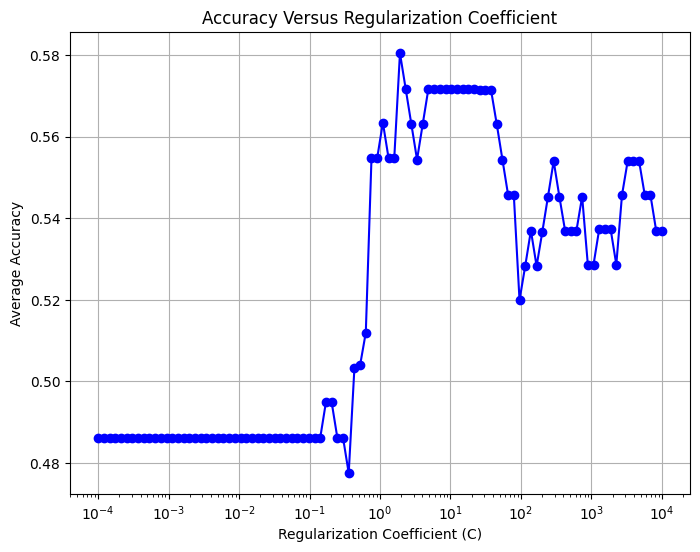

Maximum Accuracy: 0.5804
Best C:           1.9179e+00


In [ ]:
# create a logarithmically spaced set of 100 regularization coefficients in range(1e-4, 1e4)
C_values = np.logspace(-4, 4, 100)

# initialize mean accuracy list
mean_accuracies = []

# for each of the coefficients...
for C in C_values:
    # define Support Vector Classifier with new C
    svm = SVC(kernel='rbf', C=C, random_state=0)

    # perform cross fold validation
    cvs = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')

    # store mean accuracy for this C
    mean_accuracies.append(cvs.mean())

# get max accuracy and corresponding C
max_accuracy = np.max(mean_accuracies)
best_C = C_values[np.argmax(mean_accuracies)]

# plot average accuracy vs. coefficient
plt.figure(figsize=(8, 6))
plt.plot(C_values, mean_accuracies, marker='o', color='b')
plt.xscale('log')
plt.xlabel('Regularization Coefficient (C)')
plt.ylabel('Average Accuracy')
plt.title('Accuracy Versus Regularization Coefficient')
plt.grid(True)
plt.show()

# print maximum accuracy
print(f"Maximum Accuracy: {max_accuracy:.4f}")
print(f"Best C:           {best_C:.4e}")

# Support Functions

get best C and graph of accuracy for all tested Cs

In [ ]:
def get_best_C(X_cur):
  # create a logarithmically spaced set of 100 regularization coefficients in range(1e-4, 1e4)
  C_values = np.logspace(-4, 4, 100)

  # initialize mean accuracy list
  mean_accuracies = []

  # for each of the coefficients...
  for C in C_values:
    # define Support Vector Classifier with new C
    svm = SVC(kernel='rbf', C=C, random_state=0)

    # perform cross fold validation
    cvs = cross_val_score(svm, X_cur, y_train, cv=5, scoring='accuracy')

    # store mean accuracy for this C
    mean_accuracies.append(cvs.mean())

  # get max accuracy and corresponding C
  max_accuracy = np.max(mean_accuracies)
  best_C = C_values[np.argmax(mean_accuracies)]


  # plot average accuracy vs. coefficient
  plt.figure(figsize=(8, 6))
  plt.plot(C_values, mean_accuracies, marker='o', color='b')
  plt.xscale('log')
  plt.xlabel('Regularization Coefficient (C)')
  plt.ylabel('Average Accuracy')
  plt.title('Accuracy Versus Regularization Coefficient')
  plt.grid(True)
  plt.show()

  # print maximum accuracy
  print(f"Maximum Accuracy: {max_accuracy:.4f}")
  print(f"Best C:           {best_C:.4e}")
  return best_C

# Evaluating on test data for Logistic Regression

Evaluated on a variety of test features
*   Average Income and Population/Household
*   Race and Ethnicity Statistics
*   Average Income
*   All features in X_train
*   Race Statistics

Using a SVM with either Average Income and Population/Household, an accuracy of 0.625 was the maximum accuracy acheived by any of our models.




Average Income and Population/Household

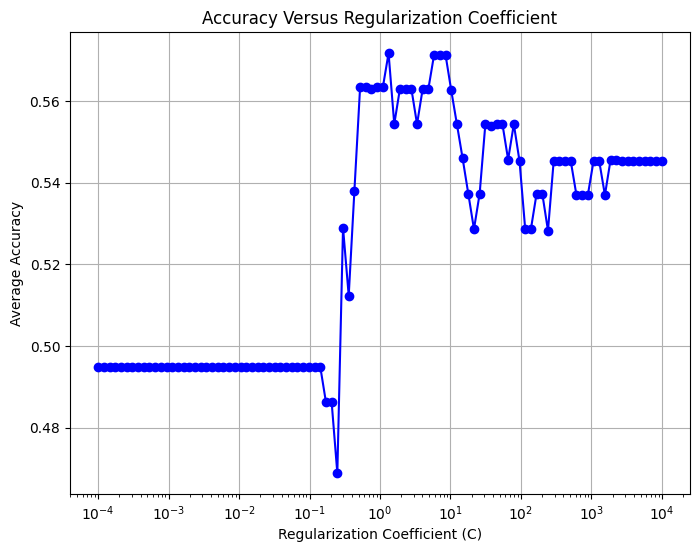

Maximum Accuracy: 0.5717
Best C:           1.3219e+00
Logistic Regression:

Accuracy: 0.5500
Confusion Matrix:
[[7 3 2]
 [2 8 3]
 [4 4 7]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.54      0.58      0.56        12
           0       0.53      0.62      0.57        13
           1       0.58      0.47      0.52        15

    accuracy                           0.55        40
   macro avg       0.55      0.56      0.55        40
weighted avg       0.55      0.55      0.55        40

-----------------------------------------------------

SVM Test:

Accuracy: 0.6250
Confusion Matrix:
[[7 5 0]
 [2 9 2]
 [4 2 9]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.54      0.58      0.56        12
           0       0.56      0.69      0.62        13
           1       0.82      0.60      0.69        15

    accuracy                           0.62        40
   macro avg       0.64      0.63

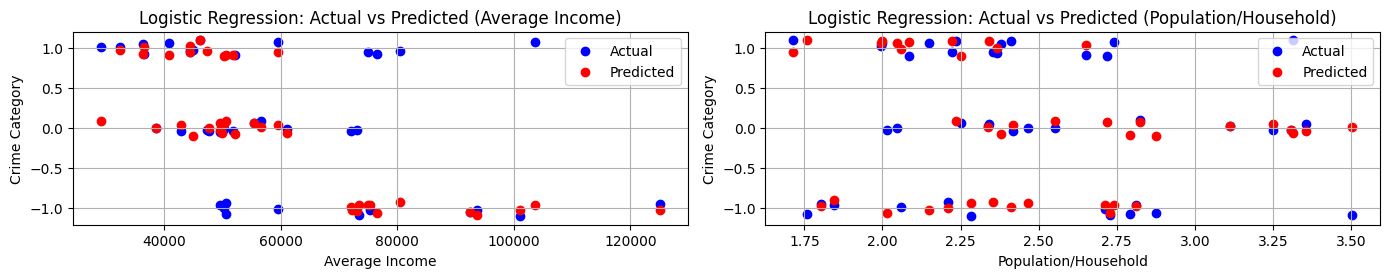

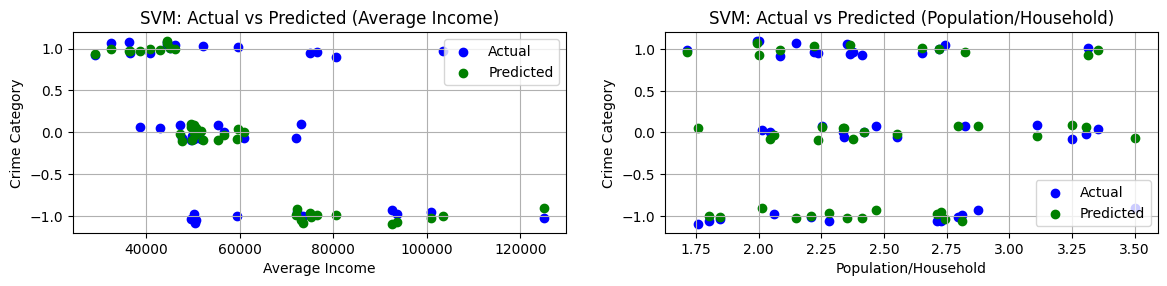

In [ ]:
# set features
X_train_temp = X_train[['Average Income', 'Population/Household']]
X_test_temp = X_test[['Average Income', 'Population/Household']]

# train Logistic Regression classifier with best C
lrCV = linear_model.LogisticRegressionCV(cv=5, max_iter=int(1e10), random_state=0, Cs=10)
lrCV.fit(X_train_temp, y_train)

# train Support Vector Machine classifier with the best C
best_C = get_best_C(X_train_temp)
svm = SVC(kernel='rbf', C=best_C, random_state=0)
svm.fit(X_train_temp, y_train)

# evaluate on the test data
y_pred_lrCV = lrCV.predict(X_test_temp)
y_pred_svm     = svm.predict(X_test_temp)

# calculate accuracy
lrCV_accuracy = accuracy_score(y_test, y_pred_lrCV)
svm_accuracy  = accuracy_score(y_test, y_pred_svm)

# define the parameters to plot
parameters = ['Average Income', 'Population/Household']

# Plot Logistic Regression results
plt.figure(figsize=(14, 10))
for i, param in enumerate(parameters):
    plt.subplot(4, 2, i + 1)
    plt.scatter(X_test_temp[[param]], y_test + np.random.uniform(-0.1, 0.1, size=y_test.shape), color='blue', label='Actual')
    plt.scatter(X_test_temp[[param]], y_pred_lrCV + np.random.uniform(-0.1, 0.1, size=y_pred_lrCV.shape), color='red', label='Predicted')
    plt.xlabel(param)
    plt.ylabel('Crime Category')
    plt.title(f'Logistic Regression: Actual vs Predicted ({param})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
# Plot SVM results
plt.figure(figsize=(14, 12))
for i, param in enumerate(parameters):
    plt.subplot(4, 2, i + 1)
    plt.scatter(X_test_temp[[param]], y_test + np.random.uniform(-0.1, 0.1, size=y_test.shape), color='blue', label='Actual')
    plt.scatter(X_test_temp[[param]], y_pred_svm + np.random.uniform(-0.1, 0.1, size=y_pred_svm.shape), color='green', label='Predicted')
    plt.xlabel(param)
    plt.ylabel('Crime Category')
    plt.title(f'SVM: Actual vs Predicted ({param})')
    plt.legend()
    plt.grid(True)

# print results
print("Logistic Regression:\n")
print(f"Accuracy: {lrCV_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lrCV))
print("Classification Report:")
print(classification_report(y_test, y_pred_lrCV))

print('-----------------------------------------------------\n')

print("SVM Test:\n")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

Race and Ethnicity Statistics

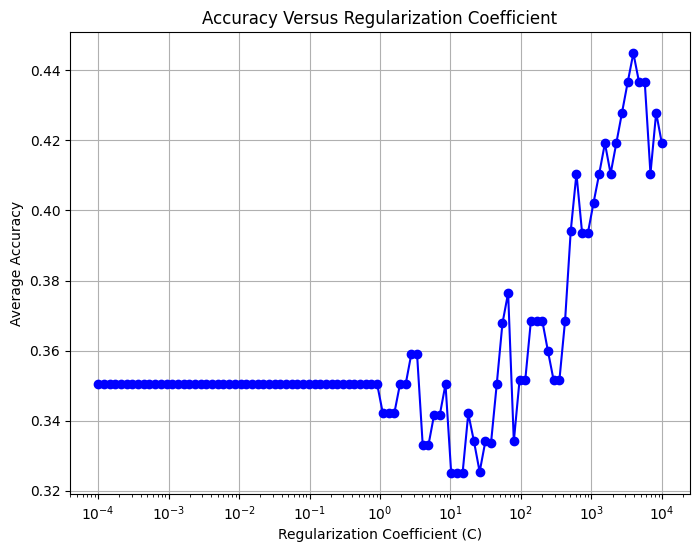

Maximum Accuracy: 0.4449
Best C:           3.9442e+03


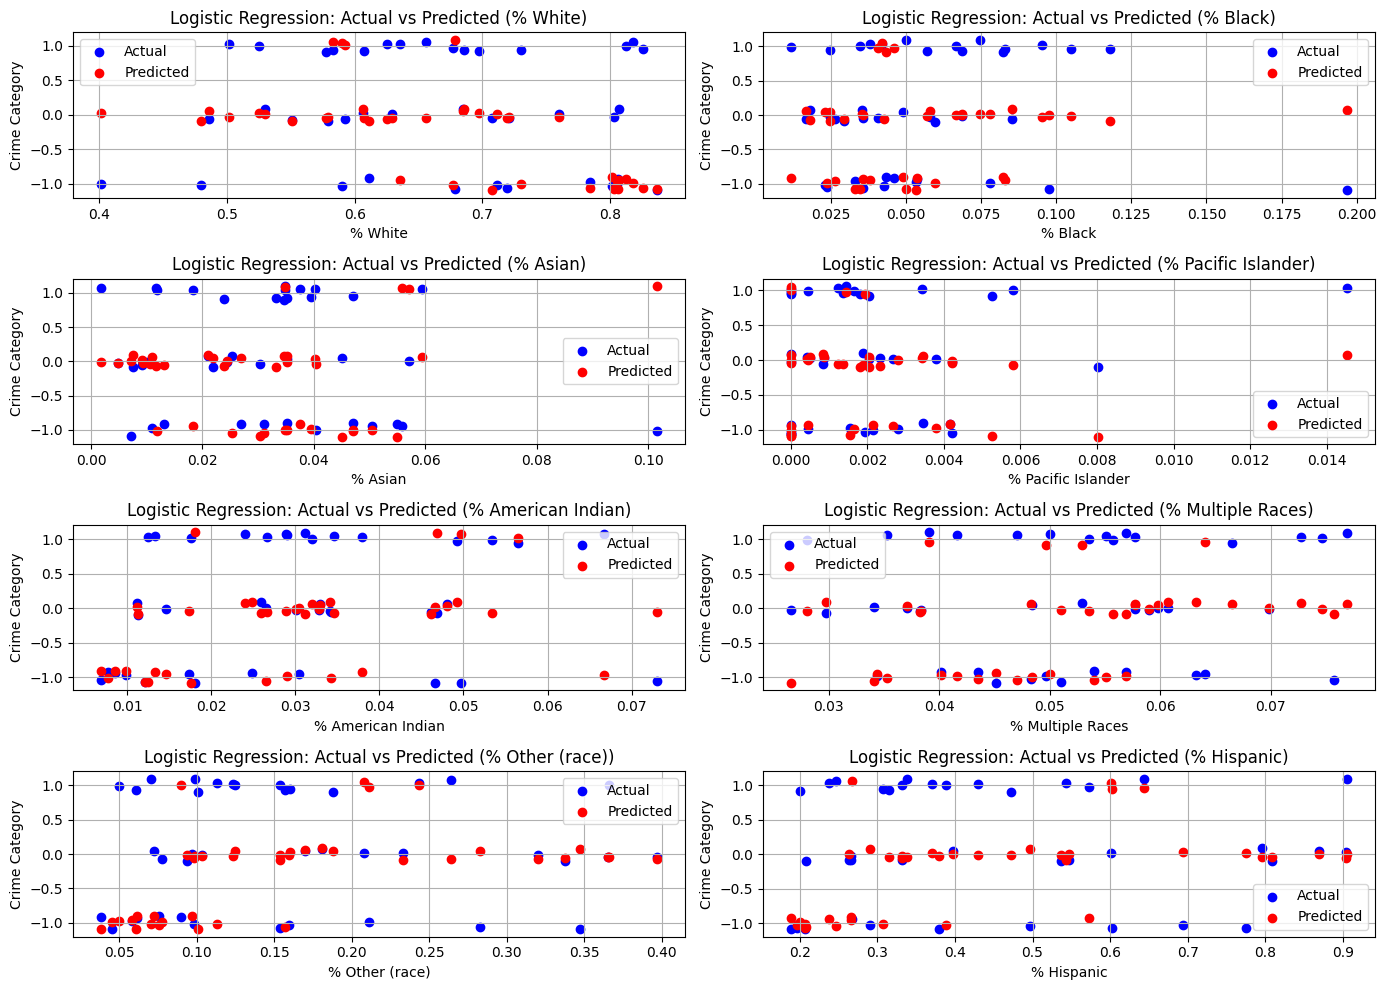

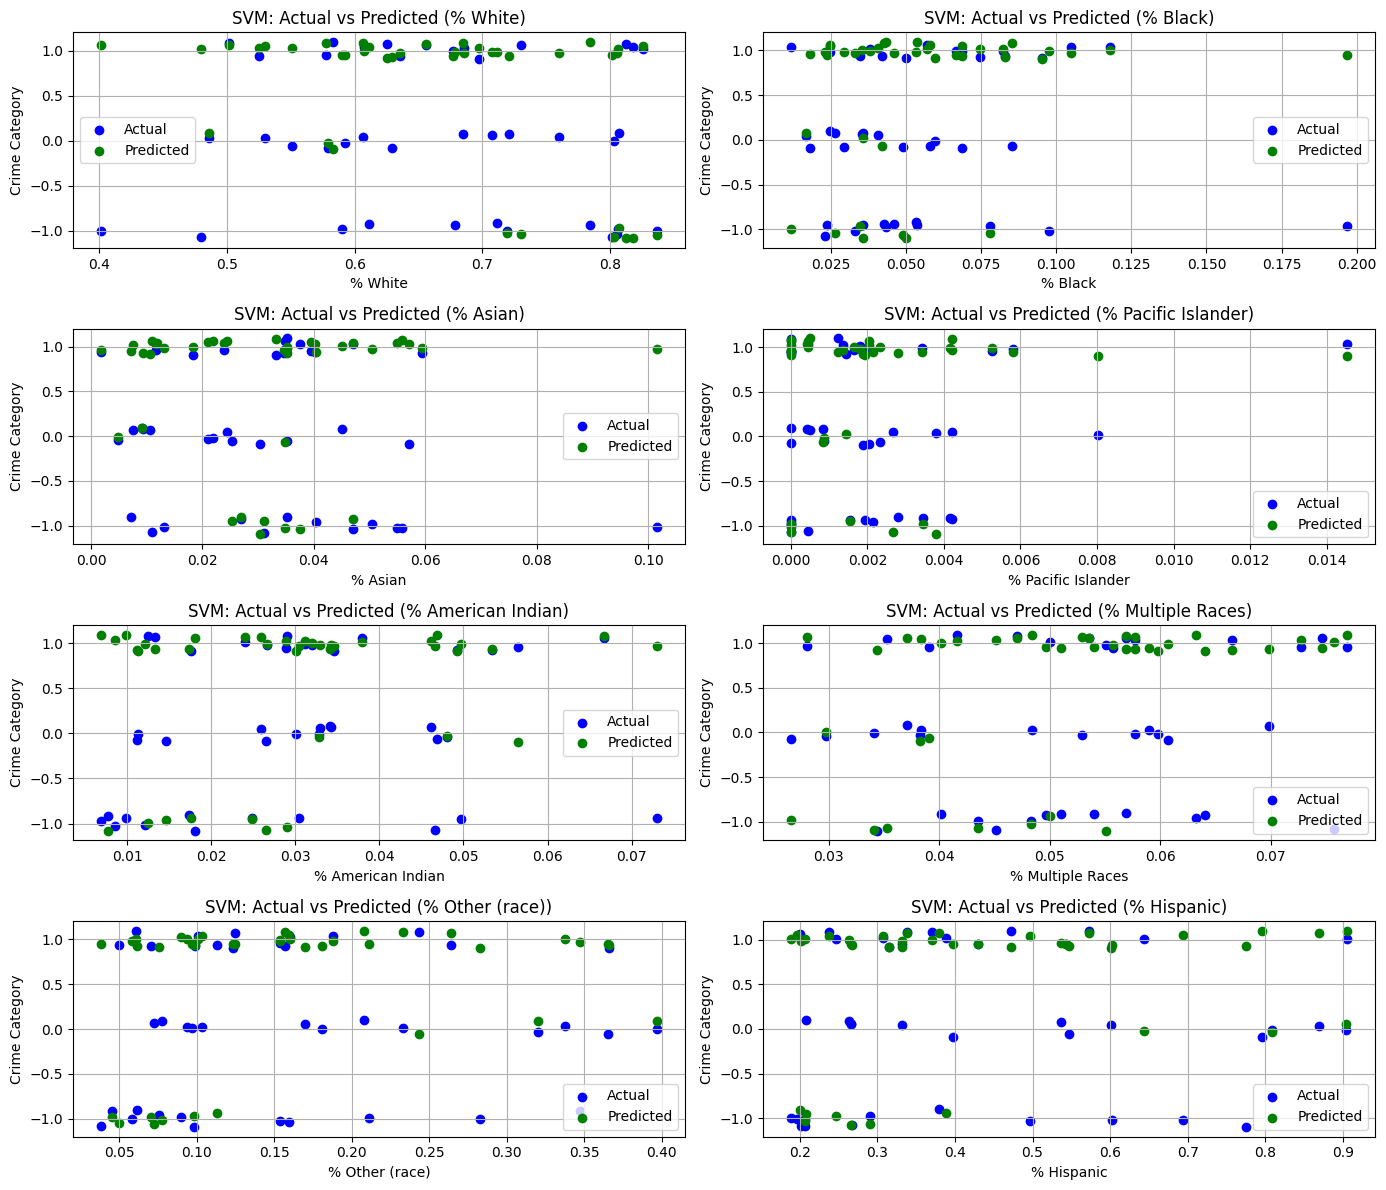

Logistic Regression:

Accuracy: 0.3750
Confusion Matrix:
[[5 5 2]
 [3 9 1]
 [6 8 1]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.36      0.42      0.38        12
           0       0.41      0.69      0.51        13
           1       0.25      0.07      0.11        15

    accuracy                           0.38        40
   macro avg       0.34      0.39      0.33        40
weighted avg       0.33      0.38      0.32        40

-----------------------------------------------------

SVM Test:

Accuracy: 0.3750
Confusion Matrix:
[[ 2  0 10]
 [ 2  2  9]
 [ 3  1 11]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.29      0.17      0.21        12
           0       0.67      0.15      0.25        13
           1       0.37      0.73      0.49        15

    accuracy                           0.38        40
   macro avg       0.44      0.35      0.32        40
weighted avg       0.44 

In [ ]:
X_train_temp = X_train.drop(columns=['Average Income', 'Population/Household'])
X_test_temp = X_test.drop(columns=['Average Income', 'Population/Household'])


# train Logistic Regression classifier with best C
lrCV = linear_model.LogisticRegressionCV(cv=5, max_iter=int(1e10), random_state=0, Cs=10)
lrCV.fit(X_train_temp, y_train)

# train Support Vector Machine classifier with the best C
best_C = get_best_C(X_train_temp)
svm = SVC(kernel='rbf', C=best_C, random_state=0)
svm.fit(X_train_temp, y_train)

# evaluate on the test data
y_pred_lrCV = lrCV.predict(X_test_temp)
y_pred_svm     = svm.predict(X_test_temp)

# calculate accuracy
lrCV_accuracy = accuracy_score(y_test, y_pred_lrCV)
svm_accuracy  = accuracy_score(y_test, y_pred_svm)

# define the parameters to plot
parameters = ['% White', '% Black', '% Asian', '% Pacific Islander', '% American Indian', '% Multiple Races', '% Other (race)', '% Hispanic']

# Plot Logistic Regression results
plt.figure(figsize=(14, 10))
for i, param in enumerate(parameters):
    plt.subplot(4, 2, i + 1)
    plt.scatter(X_test_temp[[param]], y_test + np.random.uniform(-0.1, 0.1, size=y_test.shape), color='blue', label='Actual')
    plt.scatter(X_test_temp[[param]], y_pred_lrCV + np.random.uniform(-0.1, 0.1, size=y_pred_lrCV.shape), color='red', label='Predicted')
    plt.xlabel(param)
    plt.ylabel('Crime Category')
    plt.title(f'Logistic Regression: Actual vs Predicted ({param})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
# Plot SVM results
plt.figure(figsize=(14, 12))
for i, param in enumerate(parameters):
    plt.subplot(4, 2, i + 1)
    plt.scatter(X_test_temp[[param]], y_test + np.random.uniform(-0.1, 0.1, size=y_test.shape), color='blue', label='Actual')
    plt.scatter(X_test_temp[[param]], y_pred_svm + np.random.uniform(-0.1, 0.1, size=y_pred_svm.shape), color='green', label='Predicted')
    plt.xlabel(param)
    plt.ylabel('Crime Category')
    plt.title(f'SVM: Actual vs Predicted ({param})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# print results
print("Logistic Regression:\n")
print(f"Accuracy: {lrCV_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lrCV))
print("Classification Report:")
print(classification_report(y_test, y_pred_lrCV))

print('-----------------------------------------------------\n')

print("SVM Test:\n")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

Average Income

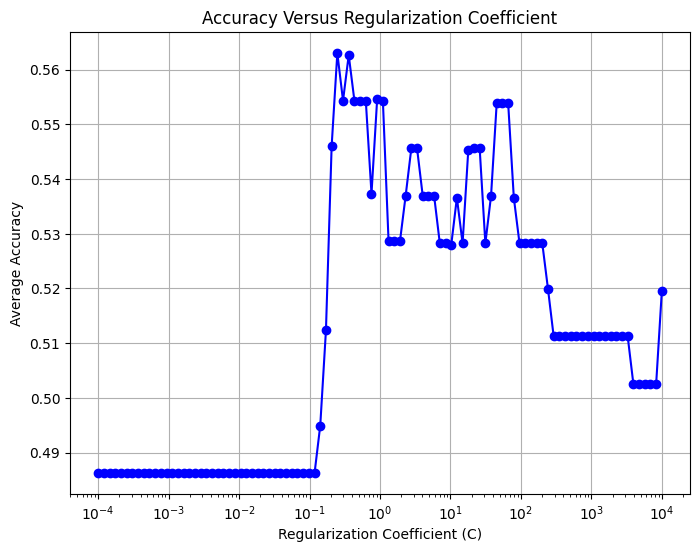

Maximum Accuracy: 0.5630
Best C:           2.4771e-01


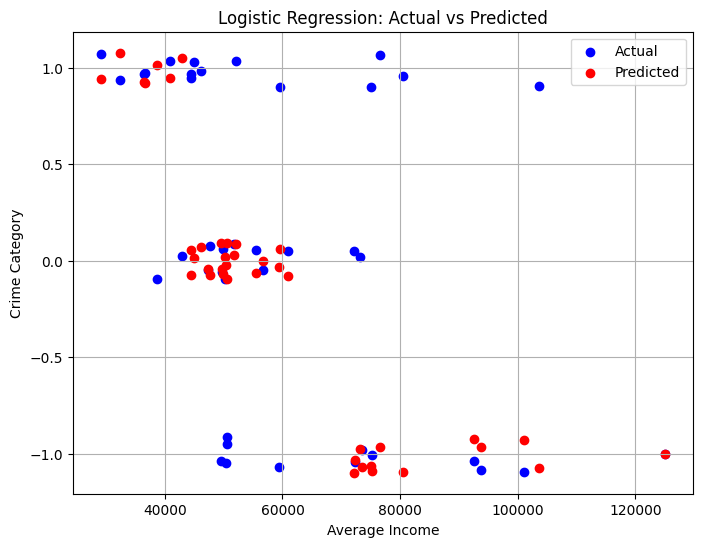

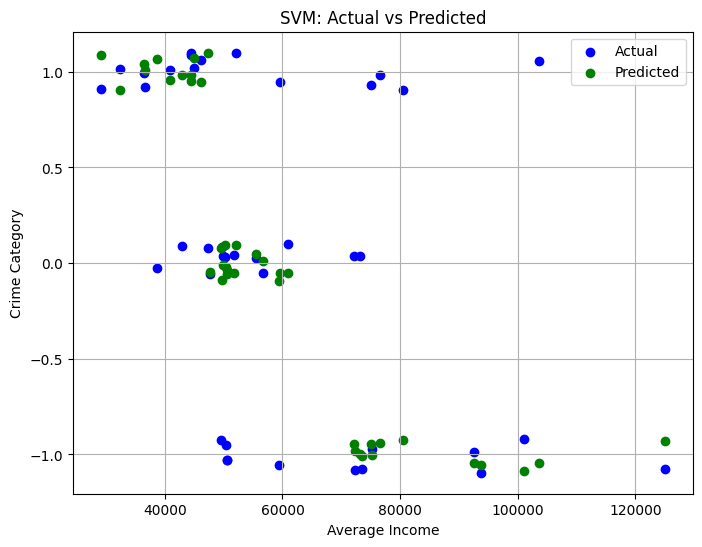

Logistic Regression:

Accuracy: 0.5250
Confusion Matrix:
[[7 5 0]
 [2 9 2]
 [4 6 5]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.54      0.58      0.56        12
           0       0.45      0.69      0.55        13
           1       0.71      0.33      0.45        15

    accuracy                           0.53        40
   macro avg       0.57      0.54      0.52        40
weighted avg       0.58      0.53      0.52        40

-----------------------------------------------------

SVM Test:

Accuracy: 0.6000
Confusion Matrix:
[[7 5 0]
 [2 8 3]
 [4 2 9]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.54      0.58      0.56        12
           0       0.53      0.62      0.57        13
           1       0.75      0.60      0.67        15

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.62      0.60

In [ ]:
X_train_temp = X_train[['Average Income']]
X_test_temp = X_test[['Average Income']]


# train Logistic Regression classifier with best C
lrCV = linear_model.LogisticRegressionCV(cv=5, max_iter=int(1e10), random_state=0, Cs=10)
lrCV.fit(X_train_temp, y_train)

# train Support Vector Machine classifier with the best C
best_C = get_best_C(X_train_temp)
svm = SVC(kernel='rbf', C=best_C, random_state=0)
svm.fit(X_train_temp, y_train)

# evaluate on the test data
y_pred_lrCV = lrCV.predict(X_test_temp)
y_pred_svm     = svm.predict(X_test_temp)

# calculate accuracy
lrCV_accuracy = accuracy_score(y_test, y_pred_lrCV)
svm_accuracy  = accuracy_score(y_test, y_pred_svm)

# plot Logistic Regression results
plt.figure(figsize=(8, 6))
plt.scatter(X_test_temp['Average Income'], y_test + np.random.uniform(-0.1, 0.1, size=y_test.shape), color='blue', label='Actual')
plt.scatter(X_test_temp['Average Income'], y_pred_lrCV + np.random.uniform(-0.1, 0.1, size=y_pred_lrCV.shape), color='red', label='Predicted')
plt.xlabel('Average Income')
plt.ylabel('Crime Category')
plt.title('Logistic Regression: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

# plot SVM results
plt.figure(figsize=(8, 6))
plt.scatter(X_test_temp['Average Income'], y_test + np.random.uniform(-0.1, 0.1, size=y_test.shape), color='blue', label='Actual')
plt.scatter(X_test_temp['Average Income'], y_pred_svm + np.random.uniform(-0.1, 0.1, size=y_pred_svm.shape), color='green', label='Predicted')
plt.xlabel('Average Income')
plt.ylabel('Crime Category')
plt.title('SVM: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


# print results
print("Logistic Regression:\n")
print(f"Accuracy: {lrCV_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lrCV))
print("Classification Report:")
print(classification_report(y_test, y_pred_lrCV))

print('-----------------------------------------------------\n')

print("SVM Test:\n")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

All features in X_train

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

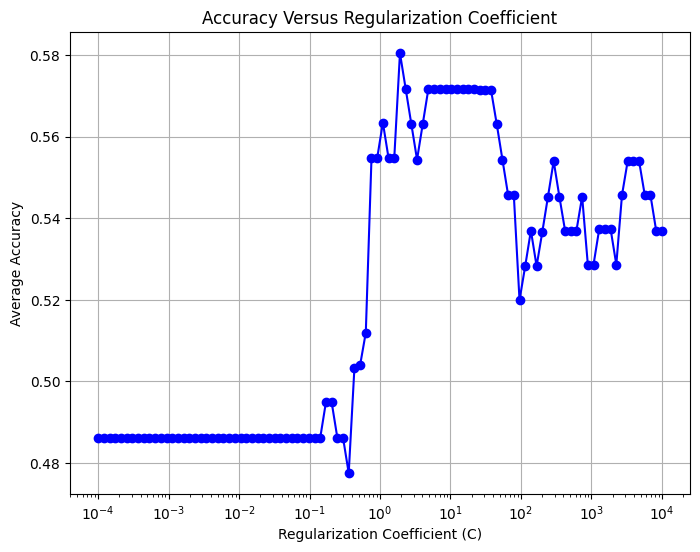

Maximum Accuracy: 0.5804
Best C:           1.9179e+00
Logistic Regression:

Accuracy: 0.4250
Confusion Matrix:
[[6 5 1]
 [3 9 1]
 [4 9 2]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.46      0.50      0.48        12
           0       0.39      0.69      0.50        13
           1       0.50      0.13      0.21        15

    accuracy                           0.42        40
   macro avg       0.45      0.44      0.40        40
weighted avg       0.45      0.42      0.39        40

-----------------------------------------------------

SVM Test:

Accuracy: 0.6250
Confusion Matrix:
[[7 5 0]
 [2 9 2]
 [4 2 9]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.54      0.58      0.56        12
           0       0.56      0.69      0.62        13
           1       0.82      0.60      0.69        15

    accuracy                           0.62        40
   macro avg       0.64      0.63

In [ ]:
# train Logistic Regression classifier with best C
lrCV = linear_model.LogisticRegressionCV(cv=5, max_iter=int(1e10), random_state=0, Cs=10)
lrCV.fit(X_train, y_train)

# train Support Vector Machine classifier with the best C
best_C = get_best_C(X_train)
svm    = SVC(kernel='rbf', C=best_C, random_state=0)
svm.fit(X_train, y_train)

# evaluate on the test data
y_pred_lrCV = lrCV.predict(X_test)
y_pred_svm  = svm.predict(X_test)

# calculate accuracy
lrCV_accuracy = accuracy_score(y_test, y_pred_lrCV)
svm_accuracy  = accuracy_score(y_test, y_pred_svm)

# print results
print("Logistic Regression:\n")
print(f"Accuracy: {lrCV_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lrCV))
print("Classification Report:")
print(classification_report(y_test, y_pred_lrCV))

print('-----------------------------------------------------\n')

print("SVM Test:\n")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

Race Statistics

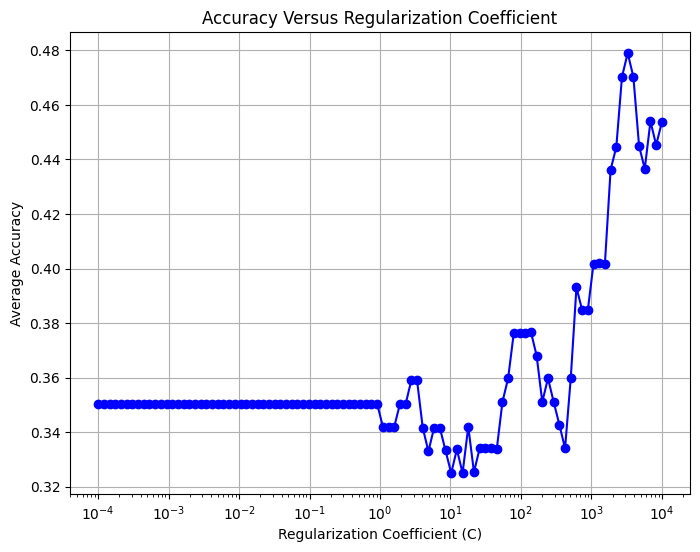

Maximum Accuracy: 0.4790
Best C:           3.2745e+03
Logistic Regression:

Accuracy: 0.3500
Confusion Matrix:
[[5 5 2]
 [4 8 1]
 [5 9 1]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.36      0.42      0.38        12
           0       0.36      0.62      0.46        13
           1       0.25      0.07      0.11        15

    accuracy                           0.35        40
   macro avg       0.32      0.37      0.32        40
weighted avg       0.32      0.35      0.30        40

-----------------------------------------------------

SVM Test:

Accuracy: 0.3500
Confusion Matrix:
[[ 2  0 10]
 [ 3  1  9]
 [ 3  1 11]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.25      0.17      0.20        12
           0       0.50      0.08      0.13        13
           1       0.37      0.73      0.49        15

    accuracy                           0.35        40
   macro avg       0.37 

In [ ]:
X_train_2 = X_train.drop(columns=['Average Income', 'Population/Household', '% Hispanic'])
X_test_2 = X_test.drop(columns=['Average Income', 'Population/Household', '% Hispanic'])

# train Logistic Regression classifier with best C
lrCV = linear_model.LogisticRegressionCV(cv=5, max_iter=int(1e10), random_state=0, Cs=10)
lrCV.fit(X_train_2, y_train)

# train Support Vector Machine classifier with the best C
best_C = get_best_C(X_train_2)
svm = SVC(kernel='rbf', C=best_C, random_state=0)
svm.fit(X_train_2, y_train)

# evaluate on the test data
y_pred_lrCV = lrCV.predict(X_test_2)
y_pred_svm     = svm.predict(X_test_2)

# calculate accuracy
lrCV_accuracy = accuracy_score(y_test, y_pred_lrCV)
svm_accuracy  = accuracy_score(y_test, y_pred_svm)

# print results
print("Logistic Regression:\n")
print(f"Accuracy: {lrCV_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lrCV))
print("Classification Report:")
print(classification_report(y_test, y_pred_lrCV))

print('-----------------------------------------------------\n')

print("SVM Test:\n")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
